In [1]:
import numpy as np
from astropy.modeling.models import Moffat1D, Moffat2D, Gaussian1D
import math
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(-60, 300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

# The Point Spread Function

What you actually see when you see a star

* With wild credit to Prof. Mario Juric, who very kindly posts all his work online.

## A star, imaged in space, with a perfect telescope and detector

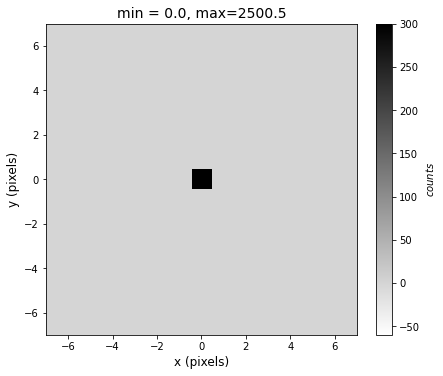

In [6]:
trueFlux = 2500.5 # true source flux (photons/sec)
xdim = 15         # width of image
ydim = 15         # height of image
Xtrue = 7         # source true x position
Ytrue = 7         # source true y position

image = np.zeros((xdim,ydim))
image[Xtrue, Ytrue] = trueFlux

plotCutout(image)

Negative images, like this one, are typical because they show faint details better.

## Actually, can't have half a photon
- Photons be quantized
- *trueFlux* is really the average rate of photons,
- actual flux is events drawn from a Poisson distribution

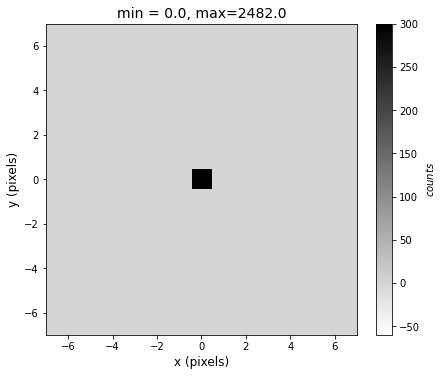

In [6]:
trueFlux = 2500.5 # true source flux (photons/sec)

np.random.seed(42)
image = np.zeros((xdim,ydim))
image[Xtrue, Ytrue] = np.random.poisson(trueFlux)

plotCutout(image)

## Usually okay to assume Gaussian noise

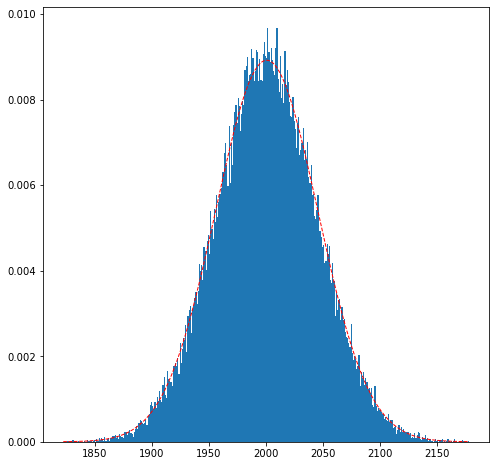

In [39]:
# take 50,000 "exposures"
np.random.seed(43)
meas = np.random.poisson(trueFlux, 50000)

nsigma = int(np.floor(4*np.sqrt(trueFlux)))
bins = np.linspace(trueFlux - nsigma, trueFlux + nsigma, 2*nsigma+1)-0.5
fig, ax = plt.subplots(figsize=(8,8))
n, bins, patches = ax.hist(meas, bins, density=True)

# since we know the trueFlux, overplot a gaussian at trueFlux 
y = scipy.stats.norm.pdf(bins, trueFlux, np.sqrt(trueFlux))
ax.plot(bins, y, 'r--', linewidth=1)

- Poisson noise is often close enough to Gaussian noise for "large N", and it's not hard to get 1000 photons
- You have to know real statistics in small-N scenerios (X-rays!)

## Real stars are never one pixel

This is a simulation from the Rubin Observatory showing how everything (the atmosphere, telescope, detector) spreads out the light. The shape of this spread is the *point spread function* (PSF)
- Note that the atmosphere has the largest effect (even on Cerro Pachon)
- For this reason the width of the PSF is often blamed entirely on the atmosphere and referred to as "the seeing"

![](psf-formation.jpg)
(credit: LSST)

## This is the Point Spread Function
- Complicated (impossible?) to derive from first principles
- Often fit with the Moffat* Function

    $$ I = I_0 [ 1 + ( \frac{r}{\gamma} )^2 ]^{-\alpha} $$

The intensity at radius $r$ (from the center of the PSF) is set by $\alpha$,  which controls the strength of the "wings", and $\gamma$, which sets the overall size of the PSF. The strength of the wings is mostly determined by atmospheric scattering. 

\* Anthony Moffat (1969, A&A, 3,455). To quote Grant M. Hill's [*An Image Quality Figure of Merit
Based on Moffat Functions?*](https://het.as.utexas.edu/HET/TechReports/moffat/moffat.html) (January 1, 2000), Moffat fit PSFs, "by convolving seeing profiles (assumed to be Gaussian) with diffraction profiles and the scattering function appropriate for photographic emulsions. Despite the relation to photographic imaging, the Moffat function has been found to work very well for fitting stellar images obtained with CCD's."

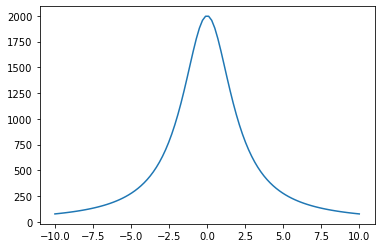

In [15]:
# Moffat functions are built into astropy (see import statements)
gamma = 2  # width
alpha = 1  # power index (shape)
PSF = Moffat1D(trueFlux, 0, gamma, alpha) 

X = np.linspace(-10,10, 100)
plt.plot(X, PSF(X) )

## Moffat functions are a better fit than Gaussians for the wings of  PSFs

![](HET_Moffat_Gaussian.gif)
<center>
Star fitted with a Moffat function (solid line) and a Gaussian (dashed line).
</center>

Hill, Grant M. *An Image Quality Figure of Merit
Based on Moffat Functions?* January 1, 2000, https://het.as.utexas.edu/HET/TechReports/moffat/moffat.html.

## But . . . a gaussian is often good enough
Moffat functions of varying power index versus Gaussian (dashed)

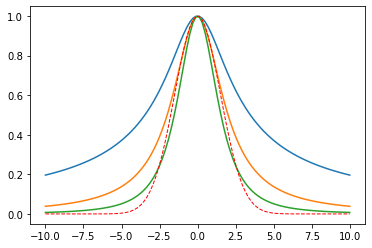

In [65]:
gamma = 2  # width of the PSF
X = np.linspace(-10,10, 100)

# now vary the power index (alpha)
for alpha in (0.5, 1, 1.5):
    PSF = Moffat1D(1, 0, gamma, alpha)
    plt.plot(X, PSF(X) )
    
gaussian = Gaussian1D(1, 0, 1.5) # amplitude, mean, stddev
plt.plot(X, gaussian(X), 'r--', linewidth=1)

Good enough, unless you have bad seeing ¯\_(ツ)_/¯

## Same star, now with PSF


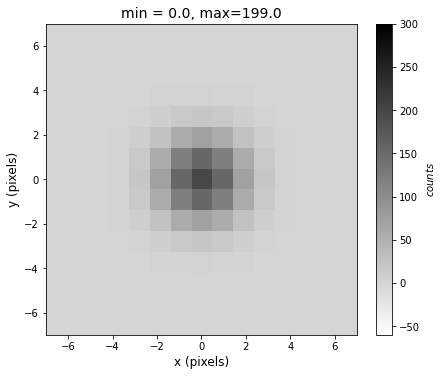

In [6]:
trueFlux = 2500.5 # true source flux (photons/sec)
xdim = 15         # width of image
ydim = 15         # height of image
sigmaPSF = 2      # in pixels, so use platescale to convert to bragging rights when at telescope

def GaussianPSF(shape, x0, y0, sigmaPSF):
    # given the shape of the 2D array and center, create a gaussian PSF
    # astropy has a Gaussian2D model already, but I just copied Mario here
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

image = np.zeros((xdim,ydim))
image = trueFlux * GaussianPSF(image.shape, 0, 0, sigmaPSF)

plotCutout(image)

## Now add sky brightness
- The Moon is often the largest source of scattered light, but city lights and even other stars contribute


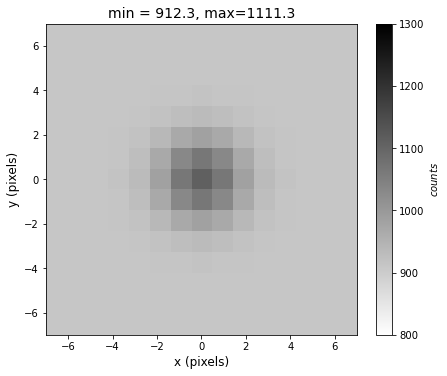

In [73]:
trueFlux = 2500.5 # true source flux (photons/sec)
xdim = 15         # width of image
ydim = 15         # height of image
Xtrue = 7         # source true x position
Ytrue = 7         # source true y position
sigmaPSF = 2      # in pixels, use platescale to convert to bragging rights when at telescope
skyBg = 912.33    # sky background (photons/sec)

image = np.zeros((xdim,ydim))
image = trueFlux * GaussianPSF(image.shape, 0, 0, sigmaPSF)
image += skyBg

plotCutout(image, clim=(800,1300))

## Oh wait, photons still quantized


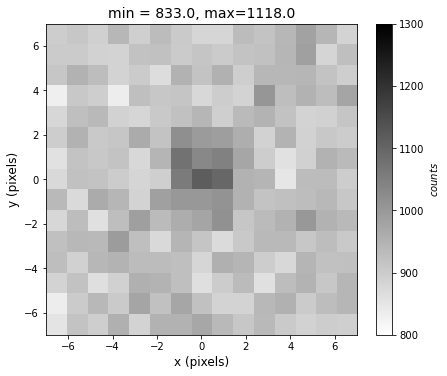

In [72]:
trueFlux = 2500.5 # true source flux (photons/sec)
xdim = 15         # width of image
ydim = 15         # height of image
Xtrue = 7         # source true x position
Ytrue = 7         # source true y position
sigmaPSF = 2      # in pixels, use platescale to convert to bragging rights when at telescope
skyBg = 912.33    # sky background (photons/sec)

image = np.zeros((xdim,ydim))
image = trueFlux * GaussianPSF(image.shape, 0, 0, sigmaPSF)
image += skyBg
image = np.random.poisson(image)

plotCutout(image, clim=(800,1300))

#### That actually looks right!

## PSF width is measured by the full-width at half-max (known as *Seeing*)
![](fwhm.png)
credit: Arne Nordmann on Wikipedia

Because seeing is mostly caused by the atmosphere, FWHM is constant across images (Assuming your telescope and detector don't have major optical aberrations.)

## Detect more stars (with less noise!) with a sharper FWHM 
- These simulated images have the same 10 stars with fluxes ranging from 500 to 5000.
- But the right image has narrower PSF

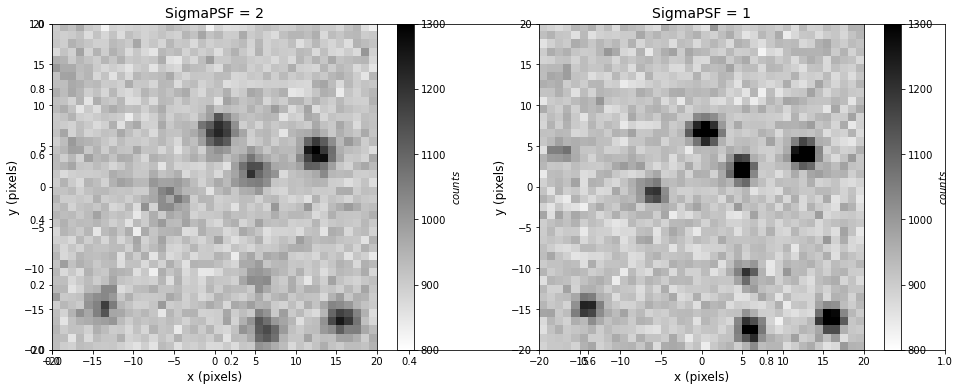

In [173]:
xdim = 40         # width of image
ydim = 40         # height of image
sigmaPSF = 2      # in pixels, so use platescale to convert to bragging rights when at telescope
skyBg = 912.33    # sky background (photons/sec)

image_broad_PSF = np.zeros((xdim,ydim)) + skyBg
image_narrowPSF = np.zeros((xdim,ydim)) + skyBg

for flux in range(500,5500,500):
    x = xdim * np.random.rand() - xdim/2.
    y = ydim * np.random.rand() - ydim/2.
    image_broad_PSF += flux * GaussianPSF(image_broad_PSF.shape, x, y, sigmaPSF)
    image_narrowPSF += flux * GaussianPSF(image_narrowPSF.shape, x, y, sigmaPSF/2)
image_broad_PSF = np.random.poisson(image_broad_PSF)
image_narrowPSF = np.random.poisson(image_narrowPSF)

fig, ax = plt.subplots(figsize=(16,6))
plotCutout(image_broad_PSF, clim=(800,1300), fig=fig, loc=121, title="SigmaPSF = 2")
plotCutout(image_narrowPSF, clim=(800,1300), fig=fig, loc=122, title="SigmaPSF = 1")

- A narrow PSF means dim stars rise above the noise
- Crowded stars are also easier to resolve (i.e. measure) with aperture photometry.

### So How Can I Get a Better PSF?

Get high and dry! 
- Seeing is mostly caused by atmosphere, although once the concrete is poored there is little we can do...

Observe near the zenith!
- Seeing (width of PSF) increases with Airmass like $s = s_0 X^{\frac{3}{5}}$

Focus briefly and often, especially at the beginning of the night.
- Telescopes cool down in the beginning of the night, so they get shorter--need to move focus out on a regular basis

Keep the mirror cool
- Warmth causes convection currents, increases seeing
